# Debugging Negative RRI Values

This notebook investigates the cause of negative RRI values in the processed ECG data, specifically focussing on ID `0244` which showed an RRI of -44.2 seconds.

In [1]:
import os
import numpy as np
import pandas as pd
import wfdb
import neurokit2 as nk
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

# --- Constants ---
ID_TARGET = "0244"
RAW_DIR = r"d:\OneDrive\Desktop\The big project\ecg-ordinal-aging\data\raw\autonomic-aging-a-dataset"
FS_INTERP = 4.0

# Check paths
record_path = os.path.join(RAW_DIR, ID_TARGET)
print(f"Target Record Path: {record_path}")

Target Record Path: d:\OneDrive\Desktop\The big project\ecg-ordinal-aging\data\raw\autonomic-aging-a-dataset\0244


## 1. Load Raw Signal

In [2]:
try:
    record = wfdb.rdrecord(record_path)
    fs = record.fs
    raw_ecg = record.p_signal[:, 0]
    print(f"Loaded {ID_TARGET}: fs={fs}, length={len(raw_ecg)}")
except Exception as e:
    print(f"Error loading record: {e}")

Loaded 0244: fs=1000, length=921855


## 2. Replicate Processing Functions
These are copied directly from `ecg_feature_extractor.py`.

In [3]:
def detect_rpeaks(raw_ecg, fs, filter_order=5):
    # Standard NeuroKit2 Clean + Peak Detect
    try:
        ecg_clean = nk.ecg_clean(raw_ecg, sampling_rate=fs)
        peaks, info = nk.ecg_peaks(ecg_clean, sampling_rate=fs)
        return info["ECG_R_Peaks"], ecg_clean
    except Exception as e:
        print(f"Peak detection failed: {e}")
        return [], None

def compute_rri(rpeaks, fs):
    times = np.array(rpeaks) / fs
    rri = np.diff(times)
    times_rri = times[1:]
    return times_rri, rri

def interpolate_rri(times_rri, rri, fs_interp=4.0, kind="quadratic"):
    times_rri = np.asarray(times_rri, dtype=float)
    rri = np.asarray(rri, dtype=float)

    # Filter valid
    m = np.isfinite(times_rri) & np.isfinite(rri)
    times_rri = times_rri[m]
    rri = rri[m]

    if times_rri.size < 2:
        return np.array([]), np.array([])

    # Uniform time grid
    t_interp = np.arange(times_rri[0], times_rri[-1] + 1e-12, 1.0 / fs_interp)

    # --- THE PROBLEMATIC LOGIC ---
    f = interp1d(
        times_rri, rri,
        kind=kind,
        bounds_error=False,
        fill_value="extrapolate",
        assume_sorted=True,
    )
    y = f(t_interp)
    return t_interp, y

## 3. Execute Processing

Detected 188 R-peaks.
Computed 187 RRI values.
Raw RRI Range: Min=0.3530s, Max=26.9370s


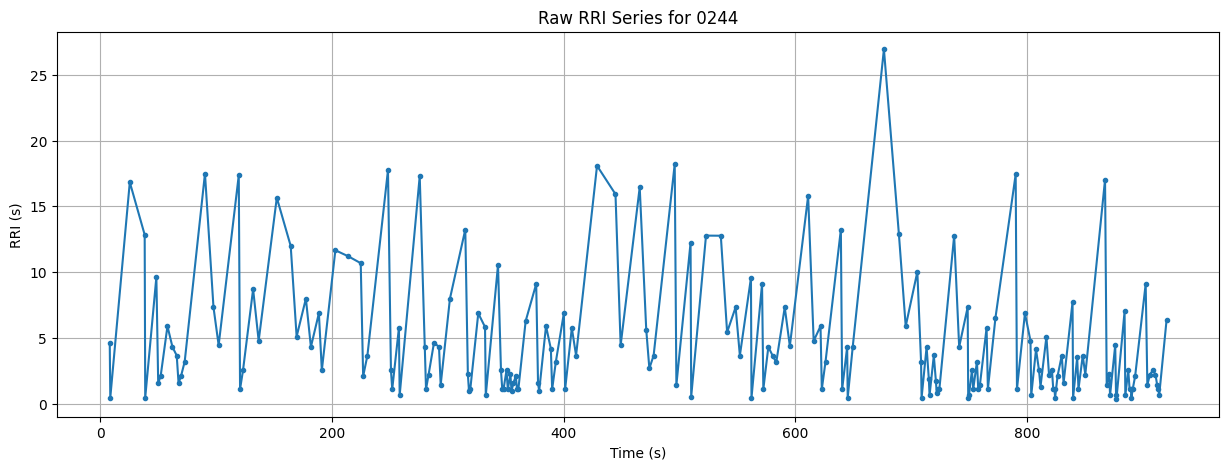

In [4]:
rpeaks, ecg_clean = detect_rpeaks(raw_ecg, fs)
print(f"Detected {len(rpeaks)} R-peaks.")

times_rri, rri = compute_rri(rpeaks, fs)
print(f"Computed {len(rri)} RRI values.")
print(f"Raw RRI Range: Min={np.min(rri):.4f}s, Max={np.max(rri):.4f}s")

# Plot Raw RRI to see outliers before interpolation
plt.figure(figsize=(15, 5))
plt.plot(times_rri, rri, 'o-', label='Raw RRI', markersize=3)
plt.title(f"Raw RRI Series for {ID_TARGET}")
plt.xlabel("Time (s)")
plt.ylabel("RRI (s)")
plt.grid(True)
plt.show()

## 4. Run Interpolation (The Suspect)
We use the exact parameters from the script: `fs_interp=4.0`, `kind='quadratic'`.

Interpolated RRI Range: Min=-44.2056s, Max=75.3910s
Count of Negative Interpolated Values: 349
First 5 bad indices: [3 4 5 6 7]
First 5 bad values: [-1.93502703 -3.94820706 -5.87530593 -7.71632364 -9.4712602 ]


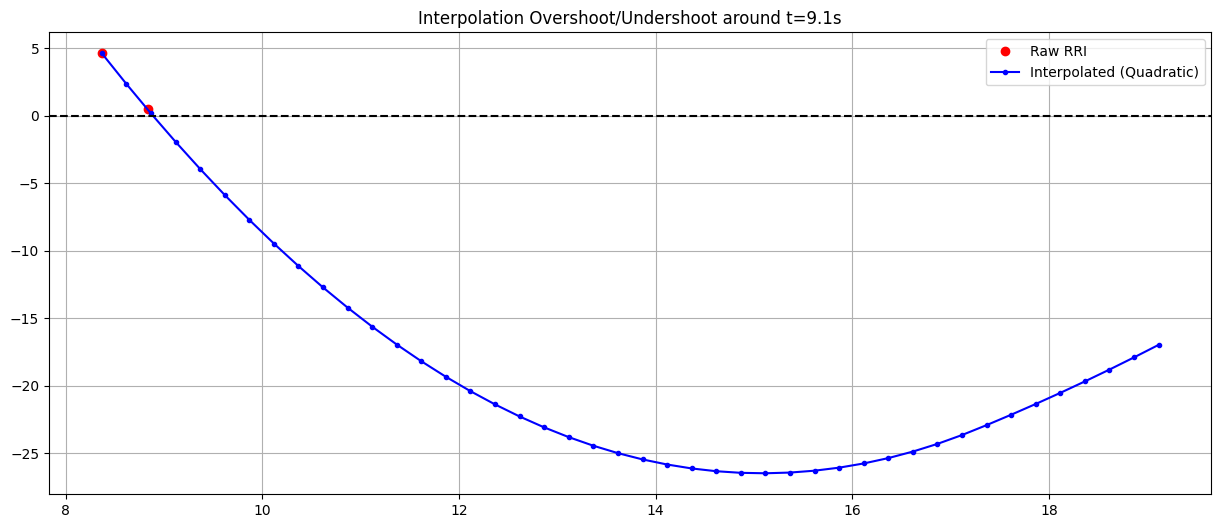

In [5]:
t_interp, rri_interp = interpolate_rri(times_rri, rri, fs_interp=FS_INTERP, kind="quadratic")

print(f"Interpolated RRI Range: Min={np.min(rri_interp):.4f}s, Max={np.max(rri_interp):.4f}s")
print(f"Count of Negative Interpolated Values: {np.sum(rri_interp <= 0)}")

# Find indices of negative values
neg_indices = np.where(rri_interp <= 0)[0]
if len(neg_indices) > 0:
    print(f"First 5 bad indices: {neg_indices[:5]}")
    print(f"First 5 bad values: {rri_interp[neg_indices[:5]]}")
    
    # Zoom into the first bad area
    bad_idx = neg_indices[0]
    t_center = t_interp[bad_idx]
    window = 10  # +/- 10 seconds
    
    mask_interp = (t_interp >= t_center - window) & (t_interp <= t_center + window)
    mask_raw = (times_rri >= t_center - window) & (times_rri <= t_center + window)
    
    plt.figure(figsize=(15, 6))
    plt.plot(times_rri[mask_raw], rri[mask_raw], 'ro', label='Raw RRI')
    plt.plot(t_interp[mask_interp], rri_interp[mask_interp], 'b.-', label='Interpolated (Quadratic)')
    plt.axhline(0, color='k', linestyle='--')
    plt.title(f"Interpolation Overshoot/Undershoot around t={t_center:.1f}s")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No negative values found in this interpolation pass!")

## 5. Proposed Fix Logic
We clip the interpolated values to a reasonable physiological range (e.g., 0.3s to 2.0s).

Clipped Range: Min=0.3000, Max=2.0000


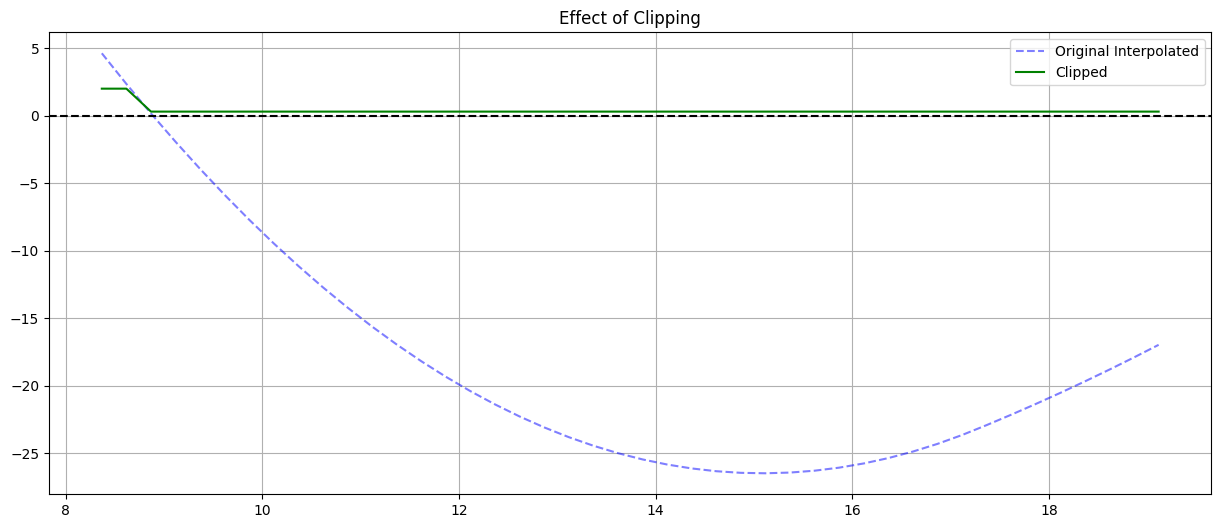

In [6]:
rri_interp_clipped = np.clip(rri_interp, 0.3, 2.0)
print(f"Clipped Range: Min={np.min(rri_interp_clipped):.4f}, Max={np.max(rri_interp_clipped):.4f}")

if len(neg_indices) > 0:
    plt.figure(figsize=(15, 6))
    plt.plot(t_interp[mask_interp], rri_interp[mask_interp], 'b--', label='Original Interpolated', alpha=0.5)
    plt.plot(t_interp[mask_interp], rri_interp_clipped[mask_interp], 'g-', label='Clipped')
    plt.axhline(0, color='k', linestyle='--')
    plt.title("Effect of Clipping")
    plt.legend()
    plt.grid(True)
    plt.show()